Paquetes necesarios

In [53]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt
import csv

TAREA: Los ejemplos ilustrativos anteriores permiten saber el número de monedas presentes en la imagen. ¿Cómo saber la cantidad de dinero presente en ella? Sugerimos identificar de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras obtener esa información y las dimensiones en milímetros de las distintas monedas, realiza una propuesta para estimar la cantidad de dinero en la imagen. Muestra la cuenta de monedas y dinero sobre la imagen. No hay restricciones sobre utilizar medidas geométricas o de color. 

Una vez resuelto el reto con la imagen ideal proporcionada, captura una o varias imágenes con monedas. Aplica el mismo esquema, tras identificar la moneda del valor determinado, calcula el dinero presente en la imagen. ¿Funciona correctamente? ¿Se observan problemas?

Nota: Para establecer la correspondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc. 

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo. 



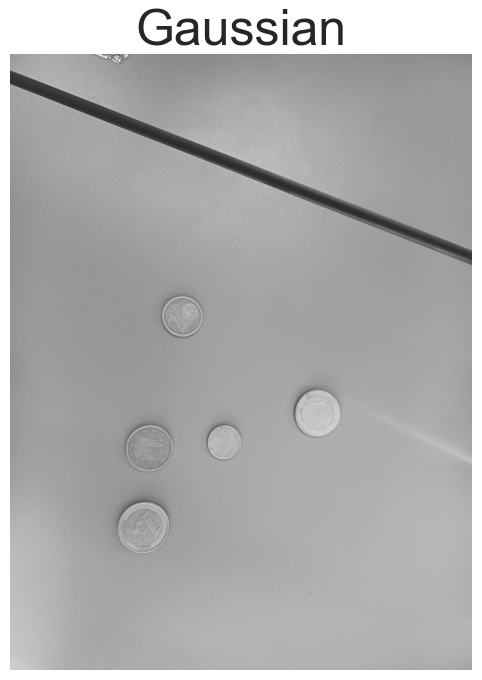

Monedas detectadas: 4


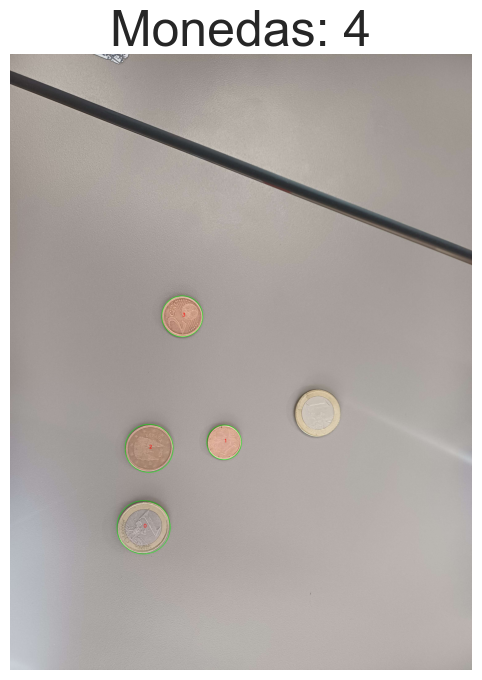

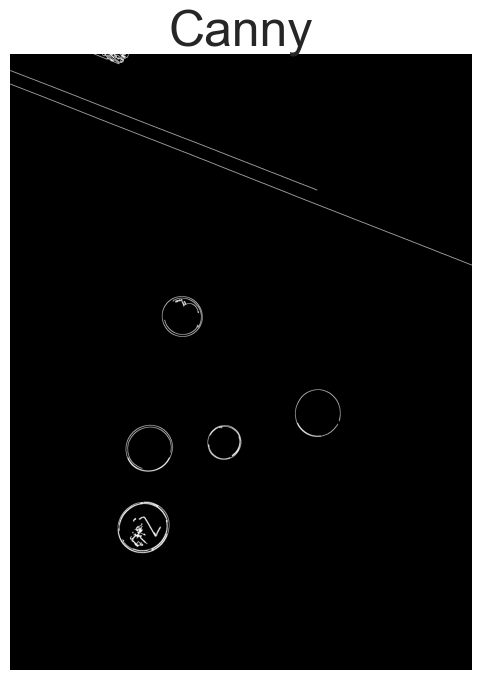

In [ ]:
# Diámetros de monedas en mm
diametros_mm = {
    2.00: 25.75,
    1.00: 23.25,
    0.50: 24.25,
    0.20: 22.25,
    0.10: 19.75,
    0.05: 21.25,
    0.02: 18.75,
    0.01: 16.25
}

# Variables globales
pixel_per_mm = None
moneda_referencia = None
moneda_seleccionada = None

def mostrar_imagen(img, titulo="Imagen", cmap=None):
    plt.figure(figsize=(10, 8))
    if cmap:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(titulo)
    plt.axis('off')
    plt.show()

# Cargar imagen
coins = cv2.imread("Monedas6.jpg")
gray = cv2.cvtColor(coins, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (7,7), 0)
mostrar_imagen(blur, "Gaussian")
# Detección de bordes con Canny
canny = cv2.Canny(blur, 20, 255)

kernel = np.ones((3,3), np.uint8)
canny = cv2.dilate(canny, kernel, iterations=1)

# Encontrar contornos
contours, hierarchy = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filtrar contornos
monedas = []
for cont in contours:
    area = cv2.contourArea(cont)
    if area > 800:  # Solo contornos grandes
        # Calcular circularidad
        perimeter = cv2.arcLength(cont, True)
        if perimeter > 0:
            circularity = 4 * np.pi * area / (perimeter * perimeter)
            
            if circularity > 0.6:  # Solo formas circulares
                (x, y), radius = cv2.minEnclosingCircle(cont)
                monedas.append({
                    'center': (int(x), int(y)),
                    'radius': int(radius),
                    'diameter_px': int(radius * 2)
                })

# Dibujar resultados
for i, moneda in enumerate(monedas):
    cv2.circle(coins, moneda['center'], moneda['radius'], (0, 255, 0), 2)
    cv2.putText(coins, str(i), moneda['center'], 
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

print(f"Monedas detectadas: {len(monedas)}")
mostrar_imagen(coins, f"Monedas: {len(monedas)}")
mostrar_imagen(canny, "Canny", cmap='gray')

Monedas detectadas: 1


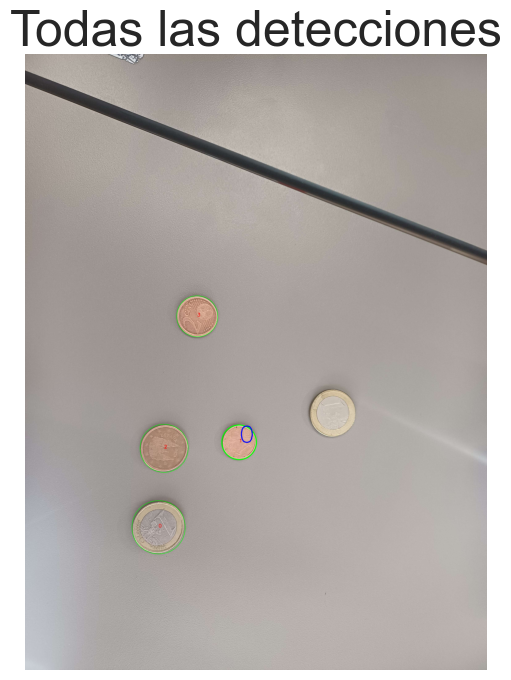

In [55]:
# PASO 1: Detectar los contornos posibles de MONEDAS
monedas = []
img_monedas = coins.copy()

for i, cont in enumerate(contours):
    # Usar minEnclosingCircle para detectar círculos
    (x, y), radius = cv2.minEnclosingCircle(cont)
    center = (int(x), int(y))
    radius = int(radius)
    
    # Calcular circularidad
    area = cv2.contourArea(cont)
    perimeter = cv2.arcLength(cont, True)
    if perimeter < 800 and perimeter > 280:
        circularity = 4 * np.pi * area / (perimeter * perimeter)
    else:
        circularity = 0
    
    if circularity > 0.6:
        monedas.append({
            'id': len(monedas),
            'center': center,
            'radius': radius,
            'diameter_px': radius * 2,
            'contour': cont,
            'circularity': circularity,
            'area': area
        })
        
        # Dibujar círculo
        cv2.circle(img_monedas, center, radius, (0, 255, 0), 5)
        cv2.putText(img_monedas, str(len(monedas)-1), center, 
                   cv2.FONT_HERSHEY_SIMPLEX, 5, (255, 0, 0), 5)

print(f"Monedas detectadas: {len(monedas)}")
mostrar_imagen(img_monedas, "Todas las detecciones")

In [56]:
# Función para calibrar con moneda de referencia
def calibrar_con_moneda_referencia(monedas, id_moneda, valor_euro):
    global pixel_per_mm, moneda_referencia
    
    if id_moneda >= len(monedas):
        print("ID de moneda inválido")
        return False
    
    moneda_ref = monedas[id_moneda]
    diametro_px = moneda_ref['diameter_px']
    diametro_mm = diametros_mm[valor_euro]
    
    pixel_per_mm = diametro_px / diametro_mm
    moneda_referencia = valor_euro
    
    print(f"Calibración completada:")
    print(f"Moneda de {valor_euro}€: {diametro_mm}mm = {diametro_px}px")
    print(f"Relación: {pixel_per_mm:.2f} píxeles/mm")
    
    return True

# Pedir al usuario que identifique una moneda de 1€
print("Identifica el ID de una moneda de 1 euro en la imagen anterior:")
id_referencia = int(input("Ingresa el ID: "))
calibrar_con_moneda_referencia(monedas, id_referencia, 1.00)

Identifica el ID de una moneda de 1 euro en la imagen anterior:
Calibración completada:
Moneda de 1.0€: 23.25mm = 224px
Relación: 9.63 píxeles/mm


True

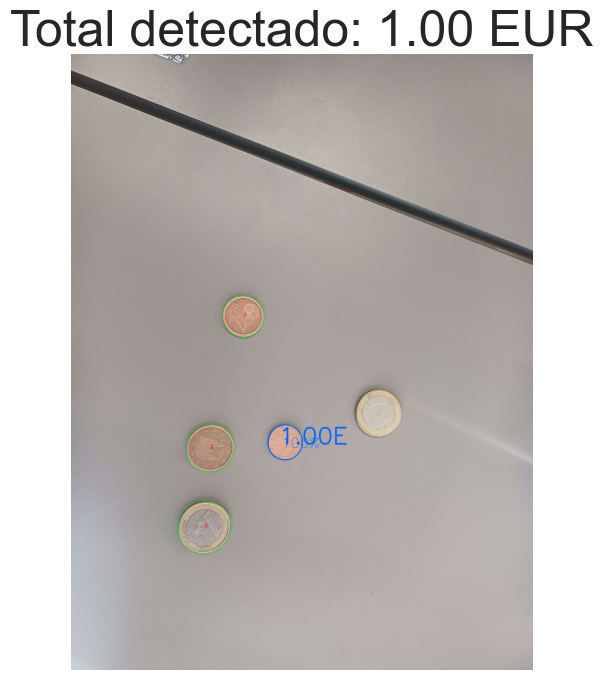


Total: 1.00 EUR


In [57]:
# PASO 2: Clasificación simplificada
def clasificar_monedas_mejorado(monedas):
    if pixel_per_mm is None:
        print("Primero debes calibrar con una moneda de referencia")
        return None, 0, None
    
    resultados = []
    total = 0
    img_resultado = coins.copy()
    
    for moneda in monedas:
        diametro_mm = moneda['diameter_px'] / pixel_per_mm
        
        # Encontrar la moneda más parecida
        mejor_match = None
        min_error = float('inf')
        
        for valor, diam_real in diametros_mm.items():
            error = abs(diametro_mm - diam_real) / diam_real
            if error < min_error:
                min_error = error
                mejor_match = valor
        
        # Si el error es aceptable (menos del 15%)
        if min_error < 0.10:
            total += mejor_match
            confianza = int((1 - min_error) * 100)
            
            # Color según confianza
            if confianza > 90:
                color = (255, 100, 0)  # Azul
            elif confianza > 85:
                color = (0, 255, 255)  # Amarillo
            else:
                color = (0, 165, 255)  # Naranja
            
            # Dibujar círculo grueso
            cv2.circle(img_resultado, moneda['center'], moneda['radius'], color, 5)
            
            # Mostrar valor grande
            texto_valor = f"{mejor_match:.2f}E"
            cv2.putText(img_resultado, texto_valor, 
                       (moneda['center'][0]-40, moneda['center'][1]+10),
                       cv2.FONT_HERSHEY_SIMPLEX, 5, color, 10)
            
            # Mostrar confianza
            texto_conf = f"{confianza}%"
            cv2.putText(img_resultado, texto_conf, 
                       (moneda['center'][0]-25, moneda['center'][1]+35),
                       cv2.FONT_HERSHEY_SIMPLEX, 3, color, 2)
    
    return resultados, total, img_resultado

# Usar la función
resultados, total, img_resultado = clasificar_monedas_mejorado(monedas)

if img_resultado is not None:
    mostrar_imagen(img_resultado, f"Total detectado: {total:.2f} EUR")
    print(f"\nTotal: {total:.2f} EUR")

In [58]:
# OPCIONAL: Función de diagnóstico para entender qué está pasando
def diagnosticar_clasificacion(monedas):
    """Muestra información detallada para entender los errores"""
    
    print("\n=== DIAGNÓSTICO DE CLASIFICACIÓN ===")
    
    for i, moneda in enumerate(monedas):
        diametro_mm = moneda['diameter_px'] / pixel_per_mm
        print(f"\nMoneda ID {i}:")
        print(f"  Circularidad: {moneda['circularity']:.3f}")
        print(f"  Diámetro detectado: {diametro_mm:.2f}mm ({moneda['diameter_px']}px)")
        print(f"  Candidatos:")
        
        # Mostrar todos los candidatos posibles
        candidatos = []
        for valor, diam_real in diametros_mm.items():
            error = abs(diametro_mm - diam_real) / diam_real * 100
            candidatos.append((error, valor, diam_real))
        
        candidatos.sort(key=lambda x: x[0])  # Ordenar por error
        
        for error, valor, diam_real in candidatos[:3]:  # Top 3 candidatos
            print(f"    {valor}€: {diam_real}mm (error: {error:.1f}%)")

# Ejecutar diagnóstico
diagnosticar_clasificacion(monedas)


=== DIAGNÓSTICO DE CLASIFICACIÓN ===

Moneda ID 0:
  Circularidad: 0.897
  Diámetro detectado: 23.25mm (224px)
  Candidatos:
    1.0€: 23.25mm (error: 0.0%)
    0.5€: 24.25mm (error: 4.1%)
    0.2€: 22.25mm (error: 4.5%)
